In [ ]:
# 하이퍼파라미터 튜닝하기

In [ ]:
# 모델을 최적화하기 위해 하이퍼파라미터를 조정하는 과정(hyperparameter optimization) 이라고도 함

In [ ]:
# Manual Search

In [ ]:
# Grid Search

In [ ]:
# Random Search

In [ ]:
# RandomizedSearchCV

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# 실습 사전 준비
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# scikit-learn과의 조합을 위해 형식을 변화 시켜야

# 1. 키워드 인자를 이용해 하이퍼파라미터를 전달받아 Sequential모델 생성 함수 
# (지정된 학습률을 사용하는 SGD 옵티마이저로 컴파일)
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
# 2. build_model함수로 만들어진 케라스 모델을 감싸는 wrapper생성
#    - kerasRegressor클래스 객체 생성
#    - 객체 생성시 하이퍼파라미터를 지정하지 않으므로 기본값을 사용하게 됨
#    - 사이킷런의 회귀 추정기 처럼 이 객체를 사용할 수 있게 됨
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# 이 객체는 fit()으로 훈련, score()로 평가하고, predict()로 예측

keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)]) # early stopping

# fit()메소드에 지정된 모든 매개변수는 케라스로 전달됨
# 사이킷런은 손실이 아니고 점수(높을수록 좋음)를 계산 -> 출력은 음수의 MSE

mse_test = keras_reg.score(X_test, y_test) # 음수로 나옴
y_pred = keras_reg.predict(X_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """


Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.2926 - val_loss: 15.7308
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7773 - val_loss: 4.9976
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5794 - val_loss: 0.5019
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4647
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4743 - val_loss: 0.4366
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4549 - val_loss: 0.4263
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4421 - val_loss: 0.4373
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4330 - val_loss: 0.4017
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.4237
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4206 - val_l

In [ ]:
print(mse_test)
print(y_pred)

-0.3404584228992462
[0.48546946 1.6598446  4.0774975  ... 1.4301839  2.3503442  4.1187744 ]


In [ ]:
# 3. 하이퍼파라미터 탐색
#    - 하이퍼파라미터가 많으므로 그리도 탐색보다 랜덤 탐색 선택 

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=2,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# .tolist() 와 rvs()메소드 등은 사이킷런의 변화로 생긴 케라스 이슈(임시 사용)
# RandomizedSearchCV는 k-겹 교차 검증을 사용
# (즉, X_valid미사용, X_valid는 EarlyStopping에 사용)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/2
242/242 [==============================] - 2s 4ms/step - loss: 0.7570 - val_loss: 7.0278
Epoch 2/2
121/121 [==============================] - 0s 1ms/step - loss: 0.4448
[CV] END learning_rate=0.013812428042938979, n_hidden=2, n_neurons=45; total time=   3.5s
Epoch 1/2
242/242 [==============================] - 1s 3ms/step - loss: 0.7744 - val_loss: 1.2835
Epoch 2/2
121/121 [==============================] - 0s 2ms/step - loss: 0.4235
[CV] END learning_rate=0.013812428042938979, n_hidden=2, n_neurons=45; total time=   2.4s
Epoch 1/2
242/242 [==============================] - 2s 4ms/step - loss: 0.9532 - val_loss: 0.7112
Epoch 2/2
121/121 [==============================] - 0s 1ms/step - loss: 0.4089
[CV] END learning_rate=0.013812428042938979, n_hidden=2, n_neurons=45; total time=   3.6s
Epoch 1/2
242/242 [==============================] - 1s 2ms/step - loss: 2.2244 - val_loss: 3.2707
Epoch 2/2
121/121 [==============

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f2db607ff90>,
                   param_distributions={'learning_rate': [0.012120191336547929,
                                                          0.004419717327341429,
                                                          0.024917037247535953,
                                                          0.011464569793723952,
                                                          0.0076034470938108265,
                                                          0.012290944092319886,
                                                          0.01061667762598564,
                                                          0.0007032165167722927,
                                                          0.019473581210363102,
                                                          0.0027988284452020703...
                                                          0.00317356208

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.028334178535698758, 'n_hidden': 3, 'n_neurons': 19}

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3812


0.38117656111717224

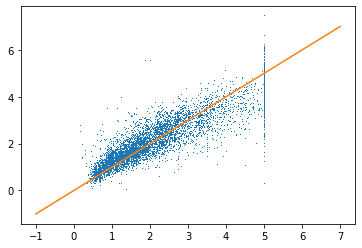

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.plot(y_test, y_pred, ',', [-1,7],[-1,7],'-')
